In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [193]:
import pandas as pd
import numpy as np
from accrual import process_crsp, process_crsp2, process_crsp3, process_compustat, merge_data, backtest

In [ ]:
data = process_crsp('data/crsp_monthly2.gz')

Total rows: 4335433
1950-01-31 00:00:00 to 2018-12-31 00:00:00
Remove all NAs: 4304938 (99.30%)
Remove Zs: 4302309 (99.24%)
Remove financials: 3168271 (73.08%)
Remove delisted rows: 3081542 (71.08%)
Remove duplicated rows: 3065321 (70.70%)
Duplicated for key [PERMNO, date]: 0


In [521]:
funda = process_compustat('data/compustat_annual.gz')

Total rows: 302087
1950-06-30 00:00:00 to 2018-12-31 00:00:00
Drop NAs: 232651 (77.01%)
Duplicated permno date: 0
Zero total asset: 23
Drop zero AT: 232628 (77.01%)
Merged with previous total asset: 211988 (70.17%)
Final rows: 211988 (70.17%)


In [36]:
merged = merge_data(data.reset_index(), funda)

Total rows: 276015
Valid PERMNO: 254461 (92.19%)
Merged: 254461 (92.19%)
Filled: 254461 (92.19%)
Drop NAs: 211696 (76.70%)


In [99]:
equity = backtest(merged)

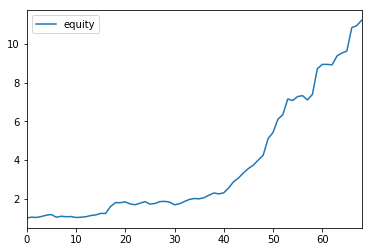

In [100]:
pd.DataFrame({'equity': (np.array(equity) + 1).cumprod()}).plot()

# New Procedure

In [13]:
crsp = process_crsp2('data/new_crsp')

Total rows: 3238267
1960-01-29 to 2018-12-31
Check missing
    date missing: 0 (0.00%)
    permno missing: 0 (0.00%)
    siccd missing: 0 (0.00%)
    ret missing: 95761 (2.96%)
Remove NAs: 3142506 (97.04%)
Remove financials: 2597216 (80.20%)
Duplicated for key [permno, date]: 0
After next return: 2573195 (79.46%)


In [31]:
funda = process_compustat('data/new_compustat')

Total rows: 302087
1950-06-30 00:00:00 to 2018-12-31 00:00:00
Drop NAs: 232771 (77.05%)
Duplicated permno date: 0
Zero total asset: 23
Drop zero AT: 232748 (77.05%)
Merged with previous total asset: 212008 (70.18%)
Final rows: 212008 (70.18%)


In [32]:
crsp['year'] = crsp.join_date.dt.year
crsp = crsp[(crsp.year >= 1962) & (crsp.year <= 2001)]
funda = funda[(funda.year >= 1962) & (funda.year <= 2001)]

In [33]:
index = ['permno', 'year']
check = pd.merge(crsp, funda[index], on=index, how='inner')
check[['year', 'permno']].drop_duplicates().shape

(126442, 2)

In [36]:
index = ['permno', 'join_date']
joined = pd.merge(crsp, funda[index + ['dwc', 'dnco', 'dnoa', 'dfin', 'tacc']], on=index, how='left')
joined = joined.groupby('permno', as_index=False).fillna(method='ffill').dropna()
print(f'After merged with fundamental: {joined.shape[0]} ({joined.shape[0] / crsp.shape[0]:.2%})')

After merged with fundamental: 1456653 (78.18%)


In [37]:
joined['year'] = joined.join_date.dt.year
joined[['year', 'permno']].drop_duplicates().shape

(135630, 2)

In [38]:
for col in ['dwc', 'dnco', 'dnoa', 'tacc']:
    joined[col[1:] + '_r'] = joined.groupby('join_date', as_index=False)[col].transform(lambda x: pd.qcut(x, 10, range(10)))

In [43]:
rank = 'nco_r'
port_ret = joined.groupby([rank, 'join_date'], as_index=False).next_ret.mean()
port_ret['cum'] = port_ret.next_ret + 1
port_ret['year'] = port_ret.join_date.dt.year
annual = port_ret.groupby([rank, 'year'], as_index=False).cum.prod()
annual = annual.pivot(index='year', columns=rank, values='cum').reset_index()
annual['hedged'] = annual[0] - annual[9]
annual[annual.year <= 2001].mean()

nco_r
year      1981.500000
0            1.242876
1            1.246651
2            1.216011
3            1.188759
4            1.166705
5            1.152784
6            1.144934
7            1.137294
8            1.110792
9            1.066497
hedged       0.176379
dtype: float64

# replicate size adjust return

In [132]:
crsp = process_crsp2('data/new_crsp')
crsp['year'] = crsp.join_date.dt.year
crsp = crsp[(crsp.cap > 0) & (crsp.year >= 1962) & (crsp.year <= 2001)]
crsp['rel'] = 1 + crsp.ret
annual = crsp.groupby(['permno', 'year'], as_index=False).agg({'cap': 'last', 'rel': 'prod'})
annual.rel = annual.rel - 1
annual['next_year'] = annual.year + 1
annual = pd.merge(annual, annual[['permno', 'year', 'rel']], left_on=['permno', 'next_year'], right_on=['permno', 'year'])
annual = annual.drop(['year_y', 'rel_x'], axis=1).rename({'rel_y': 'ret', 'year_x': 'year'}, axis=1)

Total rows: 3238267
1960-01-29 to 2018-12-31
Check missing
    date missing: 0 (0.00%)
    permno missing: 0 (0.00%)
    siccd missing: 0 (0.00%)
    ret missing: 95761 (2.96%)
    cap missing: 71070 (2.19%)
Remove NAs: 3142409 (97.04%)
Remove financials: 2597119 (80.20%)
Duplicated for key [permno, date]: 0


In [133]:
annual.head()

,permno,year,cap,next_year,ret
0,10000,1986,1.981547,1987,-0.575758
1,10001,1986,6.937000,1987,-0.101275
2,10001,1987,5.828000,1988,0.163160
3,10001,1988,6.362250,1989,0.687923
4,10001,1989,10.347750,1990,-0.008721


In [134]:
annual['size_r'] = annual.groupby('year', as_index=False).cap.transform(lambda x: pd.qcut(x, 10, range(10)))

In [136]:
annual['wgt_ret'] = annual.cap * annual.ret
size_ret = annual.groupby(['year', 'size_r'], as_index=False).agg({'wgt_ret': 'sum', 'cap': 'sum'})
size_ret['ret'] = size_ret.wgt_ret / size_ret.cap
size_adj = pd.merge(annual, size_ret[['year', 'size_r', 'ret']], on=['year', 'size_r'])
size_adj['adj_ret'] = size_adj.ret_x - size_adj.ret_y
print(size_ret.shape[0])
print(size_adj.shape[0])

390
151970


In [142]:
tmp_fund = funda.sort_values(['permno', 'join_date']).groupby(['permno', 'year'], as_index=False).last()

In [144]:
index = ['permno', 'year']
joined = pd.merge(size_adj, tmp_fund[index + ['dwc', 'dnco', 'dnoa', 'dfin', 'tacc']], on=index, how='inner')
# joined = joined.groupby('permno', as_index=False).fillna(method='ffill').dropna()

In [146]:
for col in ['dwc', 'dnco', 'dnoa', 'tacc']:
    joined[col[1:] + '_r'] = joined.groupby('year', as_index=False)[col].transform(lambda x: pd.qcut(x, 10, range(10)))

In [157]:
rank = 'nco_r'
ret_col = 'adj_ret'
port_ret = joined.groupby([rank, 'year'], as_index=False)[ret_col].mean()
port_ret = port_ret.pivot(index='year', columns=rank, values=ret_col).reset_index()
port_ret['hedged'] = port_ret[0] - port_ret[9]
port_ret.mean()

nco_r
year      1981.000000
0            0.066441
1            0.055908
2            0.059244
3            0.041181
4            0.024703
5            0.013346
6            0.009412
7            0.004933
8           -0.016137
9           -0.062436
hedged       0.128876
dtype: float64

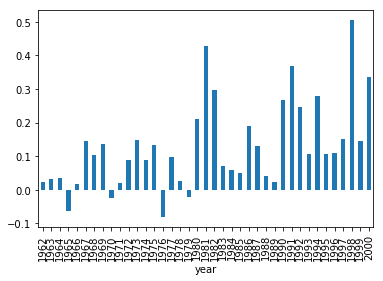

In [162]:
port_ret.set_index('year').hedged.plot(kind='bar')

# End of Replication

# Formal June Split

In [212]:
crsp = process_crsp3('data/new_crsp')
crsp['rel'] = 1 + crsp.ret
crsp = crsp.groupby(['permno', 'year'], as_index=False).agg({'rel': 'prod', 'cap': 'first'})
crsp = crsp[(crsp.year >= 1962) & (crsp.year <= 2001)]
print(crsp.shape[0])

Total rows: 3238267
1960-01-29 to 2018-12-31
Check missing
    date missing: 0 (0.00%)
    permno missing: 0 (0.00%)
    siccd missing: 0 (0.00%)
    ret missing: 95761 (2.96%)
    cap missing: 71070 (2.19%)
Remove NAs: 3142409 (97.04%)
Remove financials: 2597119 (80.20%)
Duplicated for key [permno, date]: 0
172537


In [214]:
funda = process_compustat('data/new_compustat')
funda = funda[(funda.year >= 1962) & (funda.year <= 2001)]
print(funda.shape[0])

Total rows: 302087
1950-06-30 00:00:00 to 2018-12-31 00:00:00
Drop NAs: 232771 (77.05%)
Duplicated permno date: 0
Zero total asset: 23
Drop zero AT: 232748 (77.05%)
Merged with previous total asset: 212008 (70.18%)
Final rows: 212008 (70.18%)
141429


In [215]:
funda.head(0)

,permno,date,act,at,che,dlc,dltt,ivao,ivst,lct,...,fin,avg_at,roa,dwc,dnco,dnoa,dfin,tacc,year,join_date


In [187]:
pd.merge(funda, aaa, on=['permno', 'fyear'])

,GVKEY_x,permno,date,fyear,indfmt,consol,popsrc,datafmt,conm,curcd,...,ivst,lct,lt,oiadp,pstk,sale,costat,sic,year,GVKEY_y
0,1302,22074,1987-06-30,1987.0,INDL,C,D,STD,ALLIED SUPERMARKETS,USD,...,95.676,3.724,86.117,7.159,0.000,420.579,I,5411,1987,2
1,14152,22074,1987-12-31,1987.0,INDL,C,D,STD,VONS COMPANIES INC,USD,...,NaN,310.300,902.600,NaN,0.000,NaN,I,5411,1987,2
2,5184,67563,1998-06-30,1998.0,INDL,C,D,STD,GOLDEN STATE BANCORP INC-OLD,USD,...,174.200,NaN,16878.060,286.934,4.617,1262.833,I,6035,1998,2
3,116144,67563,1998-12-31,1998.0,INDL,C,D,STD,GOLDEN STATE BANCORP INC,USD,...,52.671,NaN,52693.768,425.416,0.000,2916.987,I,6035,1998,2
4,5969,75228,1987-10-31,1987.0,INDL,C,D,STD,IVACO INDUSTRIES INC,USD,...,0.000,10.374,10.753,1.025,0.000,13.491,I,2990,1987,2
5,14446,75228,1987-12-31,1987.0,INDL,C,D,STD,IVAX CORP,USD,...,0.000,12.075,12.522,-1.505,0.000,4.240,I,2834,1987,2
6,11831,88031,1990-06-30,1990.0,INDL,C,D,STD,CONTINENTAL VENTURES INC,USD,...,NaN,0.004,0.044,0.043,0.000,0.132,I,6799,1990,2
7,24316,88031,1990-12-31,1990.0,INDL,C,D,STD,MONSTER BEVERAGE CORP,USD,...,0.000,0.178,0.215,NaN,0.000,NaN,A,2086,1990,2
8,25905,15791,2017-06-30,2017.0,INDL,C,D,STD,PACIFIC SPECIAL ACQUISITION,USD,...,0.000,1.511,1.511,-1.967,47.389,0.000,I,9995,2017,2
9,32345,15791,2017-12-31,2017.0,INDL,C,D,STD,BORQS TECHNOLOGIES INC,USD,...,3.459,92.748,101.727,6.522,0.000,154.307,A,7373,2017,2


# End June Split

In [451]:
# check rebalance portion
tmp = joined[['permno', 'join_date', 'next_join_date', 'wc_r']].copy()
aaa = pd.merge(tmp, tmp, left_on=['permno', 'next_join_date'], right_on=['permno', 'join_date'], how='inner')
aaa['same'] = aaa.wc_r_x == aaa.wc_r_y
common = aaa.groupby('join_date_x').agg({'permno': 'count', 'same': 'sum'})
common['pct'] = common.same / common.permno


nco_r
year      1984.000000
0            0.203575
1            0.203717
2            0.190798
3            0.162914
4            0.153361
5            0.138656
6            0.129647
7            0.125366
8            0.103373
9            0.048253
hedged       0.155322
dtype: float64

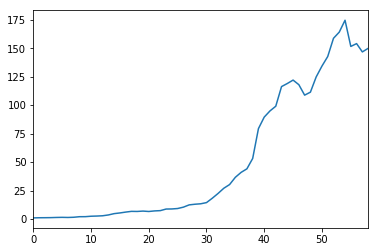

In [507]:
annual['cum'] = (1 + annual.hedged).cumprod()
annual.cum.plot(x='year')

In [488]:

annual.to_csv('data/output.csv')

In [463]:
joined.groupby(['acc_r'], as_index=False).next_ret.mean()

,acc_r,next_ret
0,0,0.015000
1,1,0.014873
2,2,0.015124
3,3,0.014481
4,4,0.014099
5,5,0.014020
6,6,0.012989
7,7,0.012637
8,8,0.011463
9,9,0.007059


In [420]:
joined.groupby('join_date').permno.nunique()['1965-01-01': ]

join_date
1965-01-31     859
1965-02-28     862
1965-03-31     864
1965-04-30     865
1965-05-31     869
1965-06-30     879
1965-07-31     882
1965-08-31     884
1965-09-30     886
1965-10-31     888
1965-11-30     886
1965-12-31     933
1966-01-31     944
1966-02-28     946
1966-03-31     946
1966-04-30     949
1966-05-31     954
1966-06-30     966
1966-07-31     974
1966-08-31     980
1966-09-30     987
1966-10-31     991
1966-11-30     996
1966-12-31    1050
1967-01-31    1058
1967-02-28    1064
1967-03-31    1069
1967-04-30    1074
1967-05-31    1076
1967-06-30    1085
              ... 
2016-06-30    2676
2016-07-31    2661
2016-08-31    2640
2016-09-30    2631
2016-10-31    2612
2016-11-30    2594
2016-12-31    2716
2017-01-31    2709
2017-02-28    2692
2017-03-31    2679
2017-04-30    2670
2017-05-31    2655
2017-06-30    2649
2017-07-31    2637
2017-08-31    2617
2017-09-30    2606
2017-10-31    2588
2017-11-30    2569
2017-12-31    2680
2018-01-31    2667
2018-02-28    2653
20

In [357]:
data.dropna(subset=['ret']).shape[0]

2597216

In [352]:
final.head()

,permno,permco,ncusip,date,ticker,shrcd,exchcd,siccd,ret,vol,...,join_date,next_ret,dwc,dnco,dfin,tacc,wc_r,nco_r,fin_r,acc_r
22,10001.0,7953,39040610,1986-06-30,GFGC,11.0,3.0,4920.0,-0.013069,238.0,...,1986-06-30,-0.010204,-0.107724,-1.213675,0.614848,-0.706551,1,0,9,0
23,10001.0,7953,39040610,1986-07-31,GFGC,11.0,3.0,4920.0,-0.010204,429.0,...,1986-07-31,0.072165,-0.107724,-1.213675,0.614848,-0.706551,1,0,9,0
24,10001.0,7953,39040610,1986-08-29,GFGC,11.0,3.0,4920.0,0.072165,895.0,...,1986-08-31,-0.003077,-0.107724,-1.213675,0.614848,-0.706551,1,0,9,0
25,10001.0,7953,39040610,1986-09-30,GFGC,11.0,3.0,4920.0,-0.003077,366.0,...,1986-09-30,0.039216,-0.107724,-1.213675,0.614848,-0.706551,1,0,9,0
26,10001.0,7953,39040610,1986-10-31,GFGC,11.0,3.0,4920.0,0.039216,362.0,...,1986-10-31,0.056604,-0.107724,-1.213675,0.614848,-0.706551,1,0,9,0


In [303]:
rets = final.groupby(['join_date', 'rwc'], as_index=False).next_ret.mean() \
            .pivot(index='join_date', columns='rwc', values='next_ret')

In [304]:
rets['longshort'] = rets[0] - rets[9]
rets['cum'] = (1 + rets.longshort).cumprod()

In [305]:
rets.tail()

rwc,0,1,2,3,4,5,6,7,8,9,longshort,cum
join_date,,,,,,,,,,,,
2018-08-31,-0.011649,-0.022242,-0.009836,0.001309,-0.003686,-0.020029,-0.011949,-0.016887,-0.037613,-0.015346,0.003697,21.175207
2018-09-30,-0.125198,-0.108234,-0.108175,-0.103784,-0.083066,-0.093558,-0.103989,-0.105563,-0.114226,-0.114264,-0.010934,20.943675
2018-10-31,-0.031853,-0.010197,-0.004096,0.000901,-0.002213,0.003640,-0.005023,0.001573,0.006829,-0.018000,-0.013853,20.653544
2018-11-30,-0.147373,-0.146765,-0.120882,-0.124657,-0.116595,-0.123654,-0.139716,-0.135871,-0.136471,-0.172779,0.025406,21.178261
2018-12-31,-0.160538,-0.148031,-0.128721,-0.121380,-0.124196,-0.123850,-0.129022,-0.137297,-0.141604,-0.152616,-0.007922,21.010478


In [254]:
np.power(21, 1/49)

1.0641039792183271

In [252]:
rets.shape[0] / 12

49.0

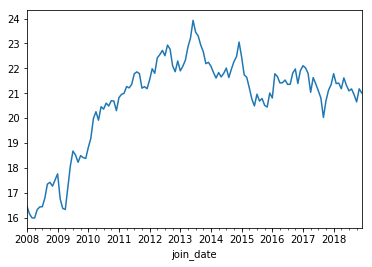

In [269]:
rets.loc['2008-01-01':].cum.plot()